# Basic Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.optim import Adam

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import ImageFolder, DatasetFolder

import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [3]:
os.chdir('/content/drive/My Drive/Colab Notebooks/comp6721')
directory_path = './'

# Loading dataset

In [4]:
def load_dataset(directory_path, test_rate=0.25):
  image_transforms = transforms.Compose(
                    [
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                     transforms.Resize((128,128))
                    ])
  
  dataset = ImageFolder(
                        root = directory_path,
                        transform = image_transforms
                        )
  train_set, test_set = torch.utils.data.random_split(dataset, [1500, 500])
  return dataset, train_set, test_set

In [5]:
dataset, train_set, test_set = load_dataset(directory_path + '/mask_dataset/')
print('Total number of images in training dataset: ',len(train_set))
print('Total number of images in testing dataset: ', len(test_set))

dataset_idxs = np.arange(len(dataset))

train_idxs = train_set.indices

test_idxs = test_set.indices

train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]
labels = np.array(dataset.targets)[dataset_idxs]

Total number of images in training dataset:  1500
Total number of images in testing dataset:  500


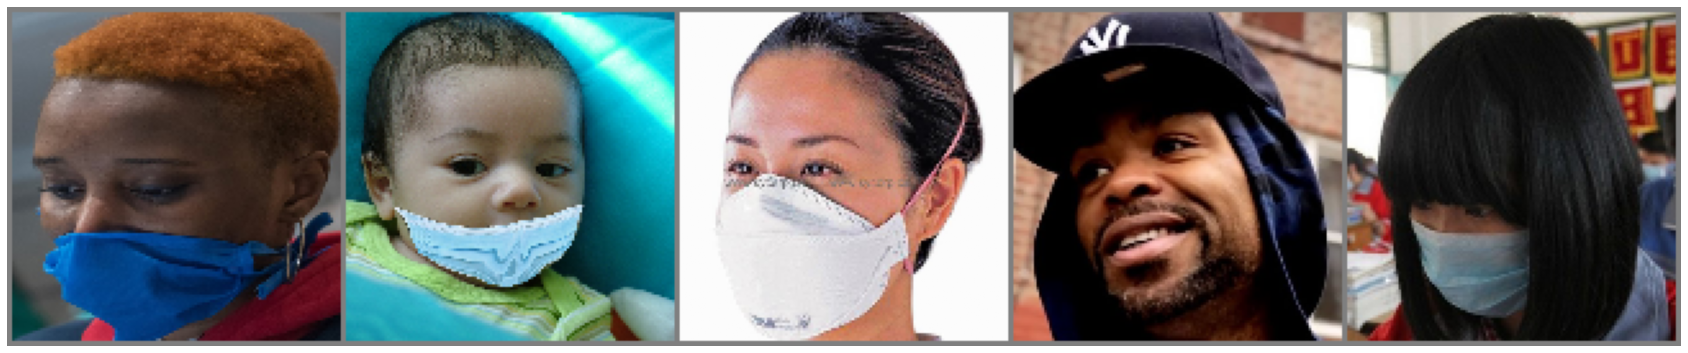

In [6]:
def show_examples(train_dataset, train_labels):
  num_classes = len(train_dataset.classes)
  train_labels_dist = Counter(train_labels)
  i = 0
  sample_idxs = []
  for j in train_labels_dist.values():
    sample_idxs.append(i)
    i = i + j
  img = make_grid([train_dataset[idx][0] for idx in sample_idxs])
  img = img / 2 + 0.5
  plt.figure(figsize=(30, 30))
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.axis('off')

show_examples(train_set.dataset, labels)

In [7]:
class_names = os.listdir(directory_path + '/mask_dataset/')
class_names.sort()
num_classes = len(class_names)
print(class_names)

['Cloth_mask', 'Mask_worn_incorrectly', 'N95_mask', 'No_mask', 'Surgical_mask']


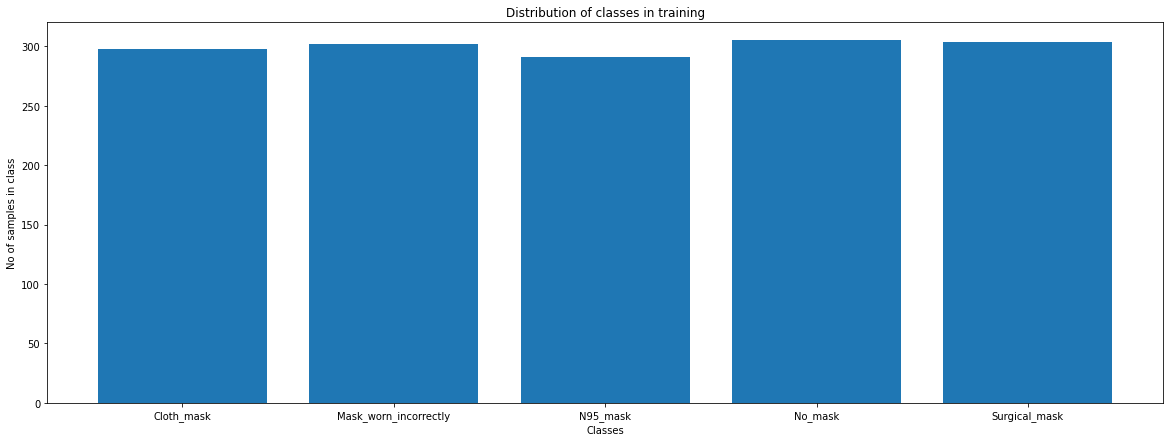

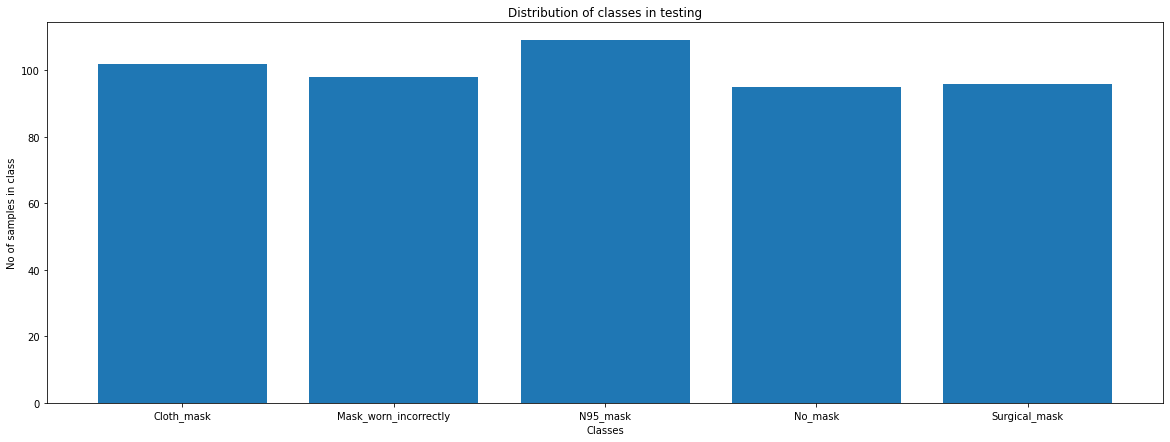

In [8]:
plt.figure(figsize=(20,7))
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(num_classes), class_names)
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())

plt.figure(figsize=(20,7))
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(num_classes), class_names)
test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values());

# CNN model

In [9]:
class CNN(nn.Module):  #CNN 
    def __init__(self, num_classes, first_pooling=True, deeper=False):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  
            nn.BatchNorm2d(64),
            nn.ReLU()   
            )  
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU()           
        )
        self.conv_layer2_without_pooling = nn.Sequential(
            nn.Conv2d(64, 128, 5, 2, 1), 
            nn.BatchNorm2d(128),
            nn.ReLU()           
        )
        self.pooling = nn.MaxPool2d(2, 2, 0)
        self.deeper_layer = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1), 
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU()    
        )
        out_channels = 256 if deeper else 128
        self.deeper = deeper
        self.first_pooling = first_pooling
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc_layer = nn.Sequential(nn.Linear(out_channels * 7 * 7, 250),
                        nn.Linear(250, num_classes))

    def forward(self, x):
        out = self.conv_layer1(x)
        if self.first_pooling:
          out = self.pooling(out)
          out = self.conv_layer2(out)
        else:
          out = self.conv_layer2_without_pooling(out)
        if self.deeper:
          out = self.pooling(out)
          out = self.deeper_layer(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return self.fc_layer(out)

# Training

In [10]:
def train(model, train_loader, lr, num_epoch, model_name):
    model.to(device)
    total_step = len(train_loader)
    optimizer = Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(train_loader):
            #print(images)
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            l = loss(outputs, labels)

            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            
            loss_val = l.item()
            acc_val = (correct / total) * 100
            
            print(f'Epoch [{epoch + 1}/{num_epoch}], Step [{i + 1}/{total_step}], Loss: {l.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')
    torch.save(model.state_dict(), f'./{model_name}-model.pt')

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 500
num_epoch = 5
lr = 0.0001

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

cuda


# Evaluation

In [12]:
def evaluate_model(model, data_loader):
    model.to('cpu')
    predictions = torch.tensor([])
    targets = torch.tensor([])
    
    for i, (images, labels) in enumerate(data_loader):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    print('accuracy: %.2f%% f1 score: %.3f precision: %.3f recall: %.3f' % (accuracy, f1, precision, recall))
    conf_matrix = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix, xticklabels=class_names, yticklabels=class_names, annot=True, cmap='Blues');
    return conf_matrix,[accuracy, f1, recall, precision]

In [13]:
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False)

## CNN training and evaluation

### training

In [14]:
normal_CNN = CNN(5)
train(normal_CNN, train_loader, lr, num_epoch, 'normal-CNN')

Epoch [1/5], Step [1/3], Loss: 1.6179, Accuracy: 17.40
Epoch [1/5], Step [2/3], Loss: 1.5698, Accuracy: 17.40
Epoch [1/5], Step [3/3], Loss: 1.2765, Accuracy: 63.40
Epoch [2/5], Step [1/3], Loss: 1.2121, Accuracy: 54.00
Epoch [2/5], Step [2/3], Loss: 1.1808, Accuracy: 54.60
Epoch [2/5], Step [3/3], Loss: 1.0138, Accuracy: 62.20
Epoch [3/5], Step [1/3], Loss: 0.9149, Accuracy: 71.60
Epoch [3/5], Step [2/3], Loss: 0.9249, Accuracy: 69.40
Epoch [3/5], Step [3/3], Loss: 0.8676, Accuracy: 70.00
Epoch [4/5], Step [1/3], Loss: 0.8384, Accuracy: 71.20
Epoch [4/5], Step [2/3], Loss: 0.8178, Accuracy: 72.40
Epoch [4/5], Step [3/3], Loss: 0.6824, Accuracy: 77.60
Epoch [5/5], Step [1/3], Loss: 0.7021, Accuracy: 76.00
Epoch [5/5], Step [2/3], Loss: 0.7192, Accuracy: 72.80
Epoch [5/5], Step [3/3], Loss: 0.6646, Accuracy: 78.40


### evaluation

accuracy: 77.40% f1 score: 0.776 precision: 0.782 recall: 0.778


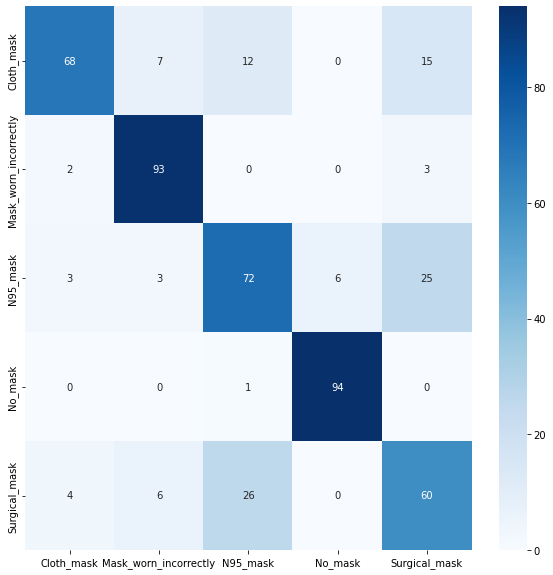

In [15]:
evaluate_model(normal_CNN, test_loader);

### clear model

In [16]:
normal_CNN = None

## CNN with less pooling training and evaluation

### training

In [17]:
CNN_less_pooling = CNN(5, False)
train(CNN_less_pooling, train_loader, lr, num_epoch, 'CNN-less-pooling')

Epoch [1/5], Step [1/3], Loss: 1.6303, Accuracy: 20.80
Epoch [1/5], Step [2/3], Loss: 1.5096, Accuracy: 23.80
Epoch [1/5], Step [3/3], Loss: 1.3215, Accuracy: 50.40
Epoch [2/5], Step [1/3], Loss: 1.2430, Accuracy: 53.20
Epoch [2/5], Step [2/3], Loss: 1.1207, Accuracy: 62.60
Epoch [2/5], Step [3/3], Loss: 1.0535, Accuracy: 66.60
Epoch [3/5], Step [1/3], Loss: 1.0069, Accuracy: 66.40
Epoch [3/5], Step [2/3], Loss: 0.9497, Accuracy: 66.40
Epoch [3/5], Step [3/3], Loss: 0.9011, Accuracy: 69.60
Epoch [4/5], Step [1/3], Loss: 0.8427, Accuracy: 73.00
Epoch [4/5], Step [2/3], Loss: 0.8548, Accuracy: 70.40
Epoch [4/5], Step [3/3], Loss: 0.7577, Accuracy: 77.00
Epoch [5/5], Step [1/3], Loss: 0.7552, Accuracy: 75.00
Epoch [5/5], Step [2/3], Loss: 0.7284, Accuracy: 75.20
Epoch [5/5], Step [3/3], Loss: 0.6823, Accuracy: 79.40


### evaluation

accuracy: 77.60% f1 score: 0.777 precision: 0.777 recall: 0.780


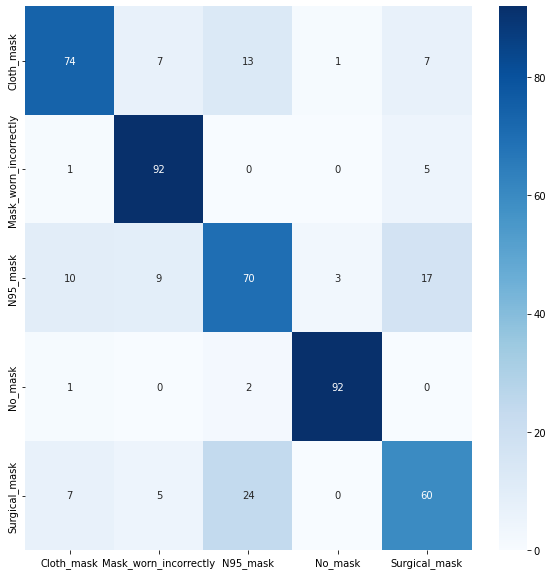

In [18]:
evaluate_model(CNN_less_pooling, test_loader);

### clear model

In [19]:
CNN_less_pooling = None

## Deeper CNN  training and evaluation

### training

In [20]:
deeper_CNN = CNN(5, False, True)
train(deeper_CNN, train_loader, lr, num_epoch, 'deeper-CNN')

Epoch [1/5], Step [1/3], Loss: 1.6011, Accuracy: 22.20
Epoch [1/5], Step [2/3], Loss: 1.2593, Accuracy: 54.80
Epoch [1/5], Step [3/3], Loss: 1.0661, Accuracy: 62.40
Epoch [2/5], Step [1/3], Loss: 0.9051, Accuracy: 66.00
Epoch [2/5], Step [2/3], Loss: 0.7926, Accuracy: 73.40
Epoch [2/5], Step [3/3], Loss: 0.7478, Accuracy: 71.80
Epoch [3/5], Step [1/3], Loss: 0.6682, Accuracy: 78.60
Epoch [3/5], Step [2/3], Loss: 0.6362, Accuracy: 76.80
Epoch [3/5], Step [3/3], Loss: 0.5853, Accuracy: 77.60
Epoch [4/5], Step [1/3], Loss: 0.5309, Accuracy: 81.00
Epoch [4/5], Step [2/3], Loss: 0.6127, Accuracy: 77.40
Epoch [4/5], Step [3/3], Loss: 0.5372, Accuracy: 81.60
Epoch [5/5], Step [1/3], Loss: 0.5024, Accuracy: 83.00
Epoch [5/5], Step [2/3], Loss: 0.4967, Accuracy: 80.60
Epoch [5/5], Step [3/3], Loss: 0.4916, Accuracy: 82.80


### evaluation

accuracy: 81.00% f1 score: 0.814 precision: 0.814 recall: 0.815


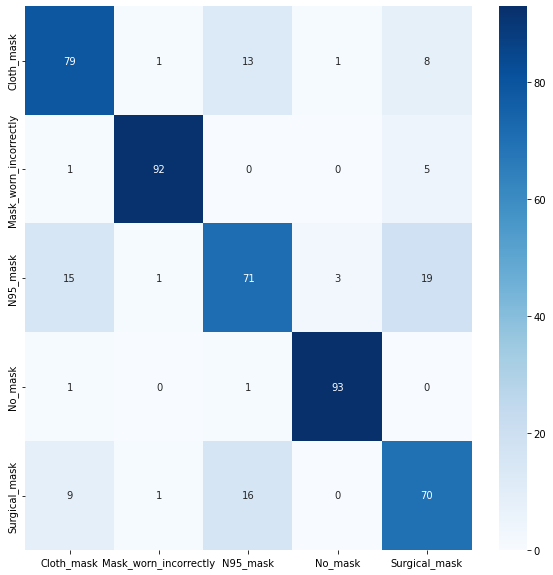

In [21]:
evaluate_model(deeper_CNN, test_loader);